### > > > Example notebook < < <
# Topological comparison of connectomes
This is the main script for topological comparisons interfacing with the [topological_comparator](https://bbpgitlab.epfl.ch/conn/personal/reimann/topological_comparator/-/tree/newbluepy) pipeline, which
 - sets up the topological comparator config files
 - creates a topological database
 - visualizes topological features of the raw and manipulated connectome

> **IMPORTANT:** This notebook is a stand-alone extension to `connectome_manipulator.ipynb`

> **REQUIREMENTS:**
> - [BluePy v2](https://bbpteam.epfl.ch/documentation/projects/bluepy/latest/) kernel!
> - [topological_sampling](https://github.com/BlueBrain/topological_sampling)/common/toposample_utilities/toposample
> - [topological_sampling](https://github.com/BlueBrain/topological_sampling)/common/pyflagsercontain
> - [pybind11](https://github.com/pybind/pybind11) in [topological_sampling](https://github.com/BlueBrain/topological_sampling)/common/pybind11

In [4]:
# Initialization
import sys
import json
import os.path
from pprint import pprint
import importlib

""" Paths """
sys.path.insert(0, '/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/')

""" Local imports """
from topological_sampling.pipeline.gen_topo_db import gen_topo_db
from topological_sampling.pipeline.count_triads import count_triads
sample_tribes_volumetric = importlib.import_module('topological_sampling.pipeline.sample_tribes.sample-tribes-volumetric') 
from topological_comparator.pipeline import prepare_pipeline
from topological_comparator.pipeline.extract_connectivity import extract_connectivity
from topological_comparator.bin import compare_topo_db
from helper_functions import plot_topodb_comparison
from helper_functions import plot_triads_comparison

In [68]:
# Config selection
topocomp_config_file = '/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/working_dir/topological_comparator/circuit-build/topocomp_config__Raw_vs_ConnRewireOrd1KeepIndeg.json'


In [69]:
# Load configuration from file
with open(topocomp_config_file, 'r') as f:
    topocomp_config = json.load(f)

# TESTING ONLY
# topocomp_config = {}
# topocomp_config['circuits'] = {'0': {'circuit_config': '/gpfs/bbp.cscs.ch/project/proj1/circuits/SomatosensoryCxS1-v5.r0/O1/merged_circuit/CircuitConfig', 'circuit_name': 'Raw'}}
# topocomp_config['circuits']['1'] = topocomp_config['circuits']['0']
# topocomp_config['out_dir'] = 'figures/SSCxO1v5'
# topocomp_config['working_dir'] = '../working_dir/topological_comparator/SSCxO1v5'

print(f'INFO: Loaded topocomp_config from {topocomp_config_file}\n')
print('topocomp_config =')
pprint(topocomp_config)

INFO: Loaded topocomp_config from /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/working_dir/topological_comparator/circuit-build/topocomp_config__Raw_vs_ConnRewireOrd1KeepIndeg.json

topocomp_config =
{'circuits': {'0': {'circuit_config': '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build/CircuitConfig',
                    'circuit_name': 'Raw'},
              '1': {'circuit_config': '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build_manip/CircuitConfig_ConnRewireOrd1KeepIndeg',
                    'circuit_name': 'ConnRewireOrd1KeepIndeg'}},
 'out_dir': 'figures/circuit-build',
 'working_dir': '../working_dir/topological_comparator/circuit-build'}


In [70]:
# Topological comparison of connectomes - Prepare topological database
topocomp_force_recomp = [False, False]
topocomp_config_files = {}
circuit_ids = sorted(topocomp_config['circuits'].keys())
for cidx in range(len(circuit_ids)):
    wrkdir = os.path.join(topocomp_config['working_dir'], topocomp_config['circuits'][circuit_ids[cidx]]['circuit_name'])
    topocomp_config_files[circuit_ids[cidx]] = os.path.join(wrkdir, 'config', 'common_config.json')
    if os.path.exists(wrkdir) and not topocomp_force_recomp[cidx]:
        print(f'INFO: Folder {wrkdir} already exists ... SKIPPING', flush=True)
    else:
        print(f'INFO: Preparing topological data in {wrkdir}', flush=True)
        # Topological database
        # TODO: CHECK base_target, CHECK topo_db config template!
        prepare_pipeline.prepare_and_place_files(topocomp_config['circuits'][circuit_ids[cidx]]['circuit_config'], 'Excitatory', wrkdir)
        extract_connectivity.main(topocomp_config_files[circuit_ids[cidx]]) # Extract connection matrices
        gen_topo_db.main(topocomp_config_files[circuit_ids[cidx]]) # Create topological database
        
        # Tribe sampling (all neurons) & triplet motifs
        with open(os.path.join(wrkdir, 'config', 'sampling_config.json'), 'r') as f: # Read sampling config
            sampling_dict = json.load(f)
#         sampling_dict['Volumetric'] = {'Specifier_label': 'Radius', 'seed': 100000, # Update volumetric sampling configuration (selecting ALL neurons by volumetric sampling) [overwriting existing config, if any]
#                                        'Specifiers': [{'name': 'All', 'value': 999999999, 'number': 1, 'neuron_count': 999999999}],
#                                        'Arguments': {'offset_amplitudes': [0, 0, 0]}}
        sampling_dict['Volumetric'] = {'Specifier_label': 'Radius', 'seed': 123123, # Update volumetric sampling configuration [overwriting existing config, if any]
                                       'Specifiers': [{'name': '100um', 'value': 100, 'number': 25, 'neuron_count': 999999999}],
                                       'Arguments': {'offset_amplitudes': [200, 200, 200]}}
        with open(os.path.join(wrkdir, 'config', 'sampling_config.json'), 'w') as f: # Write back updated config
            json.dump(sampling_dict, f, indent=2)
        sample_tribes_volumetric.main(topocomp_config_files[circuit_ids[cidx]]) # Volumetric sampling
        count_triads.main(topocomp_config_files[circuit_ids[cidx]]) # Compute over-/underexpression of triplet motifs


INFO: Folder ../working_dir/topological_comparator/circuit-build/Raw already exists ... SKIPPING
INFO: Preparing topological data in ../working_dir/topological_comparator/circuit-build/ConnRewireOrd1KeepIndeg


Using targets with population with a mvd cell file.
100% |########################################################################|
/gpfs/bbp.cscs.ch/home/pokorny/BluePy2Kernel/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Counting triads for: {'sampling': 'Radius', 'specifier': '100um', 'index': '0'}
Testing 8558 potential triadic pairs
Time spent finding triads: 0.09665250778198242
Found 9815 triads
Time spent classifying triads: 0.5555908679962158
Counting triads for: {'sampling': 'Radius', 'specifier': '100um', 'index': '1'}
Testing 12918 potential triadic pairs
Time spent finding triads: 0.1398460865020752
Found 15662 triads
Time spent classifying triads: 0.8928956985473633
Counting triads for: {'sampling': 'Radius', 'specifier': '100um', 'index': '2'}
Testing 13203 potential triadic pairs
Time spent finding triads: 0.1372992992401123
Found 16456 triads
Time spent classifying triads: 0.9895079135894775
Counting triads for: {'sampling': 'Radius', 'specifier': '100um', 'index': '3'}
Testing 11422 potential triadic pairs
Time spent finding triads: 0.12081432342529297
Found 13752 triads
Time spent classifying triads: 0.7783758640289307
Counting triads for: {'sampling': 'Radius', 'specifier': '100um', 'i

In [ ]:
# Topological comparison of connectomes - Plot topological paramter overviews
topocomp_db_dict, topocomp_param_dict = compare_topo_db.read_topo_dbs_and_parameter_specs({topocomp_config['circuits'][cidx]['circuit_name']: topocomp_config_files[cidx] for cidx in sorted(topocomp_config_files.keys())})
plot_topodb_comparison(topocomp_db_dict, topocomp_param_dict, '', topocomp_config['out_dir'], num_rows=3, show_fig=True)
plot_topodb_comparison(topocomp_db_dict, topocomp_param_dict, 'mtype', topocomp_config['out_dir'], num_rows=1, show_fig=True)
plot_topodb_comparison(topocomp_db_dict, topocomp_param_dict, 'layer', topocomp_config['out_dir'], num_rows=2, show_fig=True)


Saving /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/notebooks/figures/circuit-build/Raw_vs_ConnRewireOrd1KeepIndeg/triad_comp-Radius_100um.png...


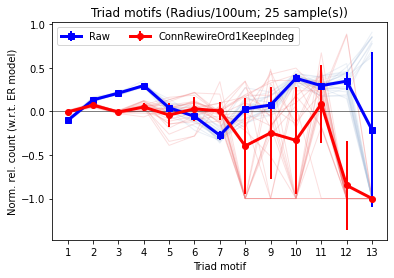

In [71]:
# Topological comparison of connectomes - Plot over-/underexpression of triad motifs
plot_triads_comparison(topocomp_config, topocomp_config_files, 'Radius/100um', topocomp_config['out_dir'], plot_single_samples=True, show_fig=True)